# Notebook 1: Introduction with Shallow Water - Williamson 2 Test Case

This notebook provides an introduction to Gusto. We will demonstrate how to set up and run a shallow water model using the geostrophic balance test case (case 2) from the Williamson et al (1992) paper, which can be found at: 
https://doi.org/10.1016/S0021-9991(05)80016-6.

The shallow water equations are written in terms of the velocity, $\textbf{u}$, and fluid depth, $D$:

\begin{align}
\textbf{u}_t + (\textbf{u} \cdot \nabla) \textbf{u} + f \textbf{u}^{\perp} + g \nabla (D + b)  &= 0, \\
D_t + \nabla \cdot (D \textbf{u}) &= 0,
\end{align}

where $f$ is the Coriolis parameter, $g$ is the gravitational acceleration, and $D = H+h-b$ is the total depth of the fluid where $H$ is the mean fluid depth, $h$ is the free surface height and $b$ is the topography. No boundary conditions are required as in this case we are solving on a spherical domain.

The problem we shall set up is a zonal geostrophic flow. This is a steady-state solution of the shallow-water equations, so the true solution does not change with time.

We begin by importing the required libraries and functions from Firedrake and Gusto. This step is required when starting any Gusto script.

In [1]:
from gusto import *
from firedrake import IcosahedralSphereMesh, SpatialCoordinate, as_vector, pi

ModuleNotFoundError: No module named 'gusto'

First we define the time-step size, `dt`, and duration of the simulation, `tmax`.

In [2]:
dt = 4000.          # timestep (in seconds)
tmax = 20*dt        # duration of the simulation (in seconds)

Next, we will construct a mesh of our domain. We will use one of the spherical meshes provided by Firedrake: the `IcosahedralSphereMesh`. As the spherical domain we are solving over is the Earth we specify the radius as 6371220m. The refinement level, `ref_level`, specifies the number of times the base icosahedron is refined, with each refinement dividing each triangular face in to 4 triangles. The argument `degree` specifies the polynomial degree of the function space used to represent the coordinates. We store the coordinates as `xyz` using the Firedrake `SpatialCoordinate` function - we will use these later whenever we set up spatially varying fields.

In [3]:
# Set up the mesh and choose the refinement level
ref_level = 3  # number of horizontal cells = 20*(4^refinements)
R = 6371220.
mesh = IcosahedralSphereMesh(radius=R, refinement_level=ref_level, degree=2)
xyz = SpatialCoordinate(mesh)

NameError: name 'IcosahedralSphereMesh' is not defined

Gusto will set up compatible finite element function spaces for the prognostic fields. These are uniquely defined by specifying the family (in this case `BDM`) of the HDiv space (used for the velocity $\textbf{u}$) and the degree (in this case `1`) of the DG space (used for the fluid depth $D$). We pass these parameters, along with the mesh and the timestep, into the `Domain` object.

In [4]:
domain = Domain(mesh, dt, "BDM", 1)

NameError: name 'Domain' is not defined

The shallow water equations contain three parameters that need to be specified: the Coriolis parameter $f=2\Omega\sin\theta$ where $\Omega$ is the rotation rate and $\theta$ the latitude, the gravitational acceleration $g$ and the mean height of the fluid layer $H$. The `ShallowWaterParameters` class has Earth-sized values as default for both $\Omega$ and $g$ (`Omega=7.292e-5`$rad/s$ and `g=9.80616`$m/s^2$) meaning that for this example we only need to specify $H$.

In [5]:
# setup shallow water parameters
H = 5960.
parameters = ShallowWaterParameters(H=H)

NameError: name 'ShallowWaterParameters' is not defined

We can now set up the finite element form of the shallow water equations by passing `domain`, `parameters` and the expression for the Coriolis parameter into the `ShallowWaterEquations` class.

In [6]:
# Create a spatially varying function for the Coriolis force:
Omega = parameters.Omega
fexpr = 2*Omega*xyz[2]/R
eqns = ShallowWaterEquations(domain, parameters, fexpr=fexpr)

NameError: name 'parameters' is not defined

We specify output option using the `OutputParameters` class. The directory name, `dirname`, must be specified. To prevent losing hard-earned simulation data, Gusto will not allow existing files to be overwritten. Hence, if one wishes to re-run a simulation with the same output filename, the existing results file needs to be moved or deleted first. This is also the place to specify the output frequency (in timesteps) of vtu files. The default is `dumpfreq=1` which outputs vtu files at every timestep (very useful when first setting up a problem!). Below we set `dumpfreq=5`.

In [7]:
output = OutputParameters(dirname="williamson_2", dumpfreq=5)

NameError: name 'OutputParameters' is not defined

We can specify which diagnostics to record over a simulation. The list of avaliable diagnostics can be found in the gusto source code: https://github.com/firedrakeproject/gusto/blob/main/gusto/diagnostics.py. Since this flow should be in a steady state, it is also instructive to output the steady state error fields for both $\textbf{u}$ and $D$ as this will tell us how close the simulation is to being correct. They will not be identically zero, due to numerical discretisation error, but the errors should not grow in time and they should reduce as the mesh and timestep are refined. We pass these diagnostics into the `IO` class, which controls the input and output and stores the fields which will be updated at each timestep.

In [8]:
diagnostic_fields = [SteadyStateError('u'), SteadyStateError('D'),
                     RelativeVorticity(), PotentialVorticity(),
                     ShallowWaterKineticEnergy(),
                     ShallowWaterPotentialEnergy(parameters),
                     ShallowWaterPotentialEnstrophy(),
                     CourantNumber()]

io = IO(domain, output=output, diagnostic_fields=diagnostic_fields)

NameError: name 'SteadyStateError' is not defined

Now we will choose a timestepper. One option is to use the `SemiImplicitQuasiNewton` approach. This approach splits the equation into 'transport' terms and 'forcing' terms (i.e. everything that's not transport) and solves each separately. This allows for different time-steppers to be used for transporting the velocity and depth fields. We choose to use an Implicit Midpoint method for the velocity and an explicit strong stability preserving RK3 (SSPRK3) method for the depth. Since the Courant number for a stable SSPRK3 scheme is lower than that for the Implicit Midpoint method, we do 2 subcycles of the SSPRK3 scheme per timestep, allowing us to use a longer timestep overall. We apply the `DGUpwind` method to the transport terms for both fields. A full list of avaliable time stepping methods can be found at: https://github.com/firedrakeproject/gusto/blob/main/gusto/time_discretisation.py.

In [9]:
transported_fields = [TrapeziumRule(domain, "u"),
                      SSPRK3(domain, "D", fixed_subcycles=2)]
transport_methods = [DGUpwind(eqns, "u"), DGUpwind(eqns, "D")]
stepper = SemiImplicitQuasiNewton(eqns, io, transported_fields,
                                  transport_methods)

NameError: name 'TrapeziumRule' is not defined

We are now ready to specify the initial conditions:
\begin{align}
\textbf{u}_0 &= \frac{u_{max}}{R} [-y,x,0], \\
D_0 &= H - \frac{\Omega u_{max} z^2}{g R}.
\end{align}
For the $D$ field we can simply interpolate the expression above; for the $\textbf{u}$ field we will need to project because interpolation is not implemented for functions on HDiv spaces.

In [10]:
u0 = stepper.fields("u")
D0 = stepper.fields("D")
day = 24*60*60
u_max = 2*pi*R/(12*day)  # Maximum amplitude of the zonal wind (m/s)
uexpr = as_vector([-u_max*xyz[1]/R, u_max*xyz[0]/R, 0.0])
g = parameters.g
Dexpr = H - ((R * Omega * u_max)*(xyz[2]*xyz[2]/(R*R)))/g
u0.project(uexpr)
D0.interpolate(Dexpr)

NameError: name 'stepper' is not defined

When using the `SemiImplicitQuasiNewton` timestepper, we also have to set up any non-zero reference profiles.

In [11]:
Dbar = Function(D0.function_space()).assign(H)
stepper.set_reference_profiles([('D', Dbar)])

NameError: name 'Function' is not defined

We are ready to run our simulation! We simply instruct the time-stepper to run for the specified duration.

In [12]:
# Run the timestepper and generate the output.
stepper.run(t=0, tmax=tmax)

NameError: name 'stepper' is not defined

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
from firedrake import trisurf

ModuleNotFoundError: No module named 'firedrake'

After the simulation is completed, you should see that there is now a 'results' directory, with a sub-directory containing the output of this simulation. The output at the specified times is saved in a .vtu format that can be viewed using Paraview. There are five files, corresponding to the specified dump times (field_output_1.vtu, field_output_2.vtu, .., field_output_5.vtu), as well as one for the initial conditions (field_output_0.vtu). Paraview can be downloaded from the following link: https://www.paraview.org/.

This test case should generate a steady state solution. Running the cell below will use Matplotlib to plot the error in the depth field (i.e. the difference between the depth field at the end of the simulation and that at the start). The velocity and depth fields are visualised below.

NameError: name 'trisurf' is not defined

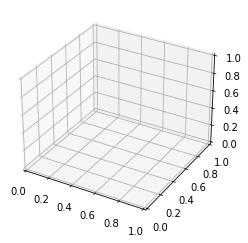

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ts=trisurf(stepper.fields('D_error'), axes=ax, cmap=cm.coolwarm)
fig.colorbar(ts, shrink=0.5, aspect=5)
plt.show()

Velocity magnitude:
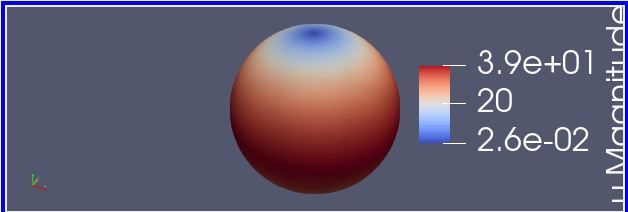

Depth field:
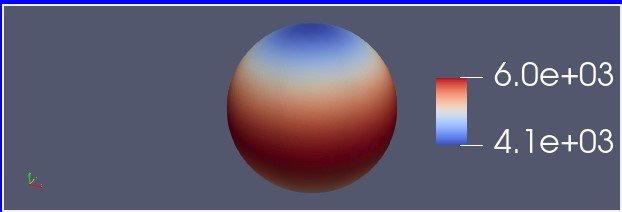

Congratulations, you have now successfully run a Gusto script!